# MERTK+ & NK Analysis
1. Are the MERTK+ cells not being called because the significant genes are not connected in pathways as would be required by scGWAS?
2. Is scGWAS calling NK-8 but not other clusters because of the pathways or genes not identified as significant by scDRS?

In [2]:
library(data.table)
library(ggplot2)
library(Matrix)
library(anndata)
library(dplyr)
library(plyr)
library(dplyr)
library(tidyverse)
library(cowplot)

## 0. Original python code to get the appropriate cell types:

## 1. MERTK+: Are the MERTK+ cells not being called because the significant genes are not connected in pathways as would be required by scGWAS?
mertk_clusters <- unique(meta_data$cluster_name[grep("MERTK", meta_data$cluster_name)])
mertk_clusters

### Read in data

In [3]:
## # pathway commons network file
path <- fread("~/Downloads/PathwayCommons12.All.hgnc.exPCDHA.MHC.NCBI37.tsv", header=FALSE)
dim(path)
path[1:2,]

[1] 805375      2

V1,V2
<chr>,<chr>
A1BG,A2M
A1BG,ABCC6


V1,CORR,RANK
<chr>,<dbl>,<int>
MAMDC2,0.2922804,0
COLEC12,0.2659531,1


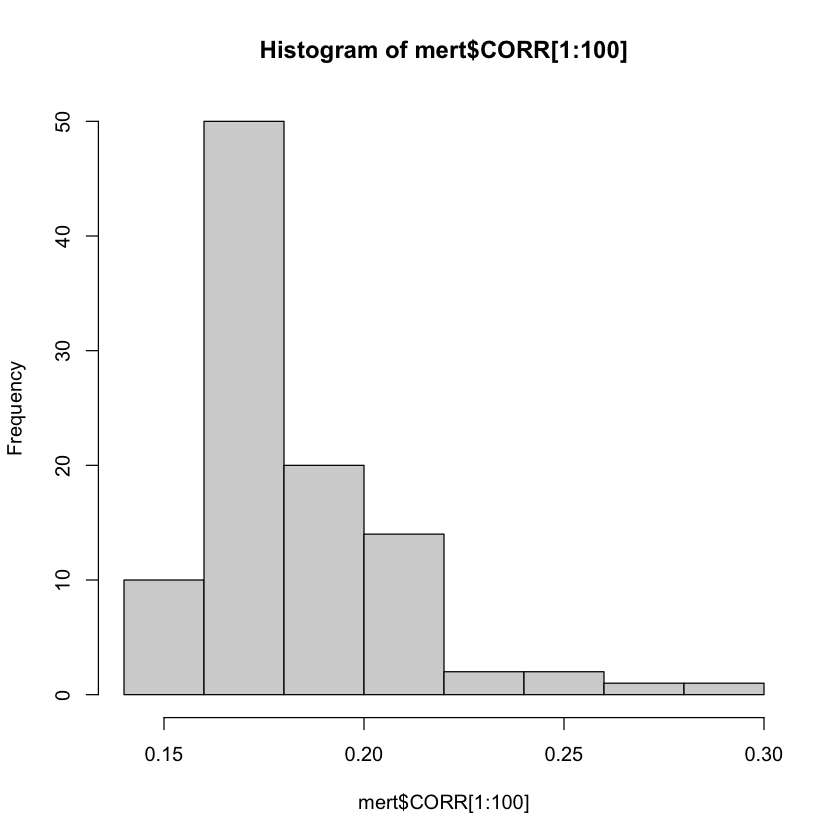

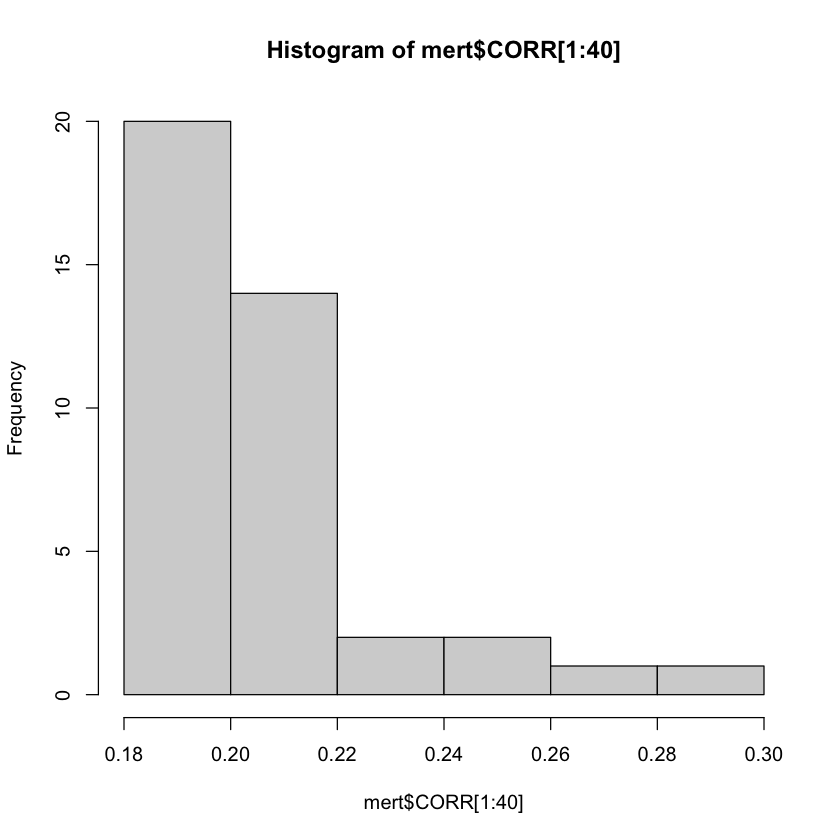

In [4]:
# scDRS MERTK ranking
mert <- fread("~/Downloads/RA_MERTK+.scdrs_gene")
mert[1:2,]

#hist(mert$CORR)
hist(mert$CORR[1:100])
hist(mert$CORR[1:40])

### Get the genes shared

In [5]:
# see what are not shared at all
shared <- intersect(mert$V1, c(path$V1, path$V2))
length(unique(mert$V1))
length(unique(path$V1))
length(shared)

[1] 17084

[1] 15822

[1] 13336

In [6]:
# only keep the info regarding the genes shared
shared <- intersect(mert$V1, c(path$V1, path$V2))
mert <- data.frame(mert[mert$V1 %in% shared,])
path <- path[path$V1 %in% shared | path$V2 %in% shared,]


### See if the genes 'ranked highest' by scDRS have corresponding gene networks
1. Get all the combined networks of genes with the top 50 correlated

In [12]:
# get the list of genes connected to the top 30

df <- data.frame(data.table("MERTK_Gene"=c(), "MERTK_CORR"=c(), 
                            "PATH_Gene"=c(), "PATH_CORR"=c()))
top_df <- data.frame(data.table("MERTK_Gene"=c(), "MERTK_CORR"=c(), 
                            "PATH_Gene"=c(), "PATH_CORR"=c()))
for (indx in seq(1,30)) {
    gene <- mert$V1[indx]
    filtered <- path[path$V1 == gene | path$V2 == gene,]
    add = unique(c(filtered$V1, filtered$V2))
    add = setdiff(add, gene)
    path_corr <- mert[mert$V1 %in% add,]
    rownames(path_corr) <- path_corr$V1
    path_corr <- path_corr[add,]
    add_df = data.frame(data.table("MERTK_Gene"=rep(gene, length(add)), 
                                   "MERTK_CORR"=rep(mert$CORR[indx], length(add)), 
                                   "PATH_Gene"=add, 
                                   "PATH_CORR"=path_corr$CORR))
    max_corr = max(add_df$PATH_CORR, na.rm=T)
    top_add_df = data.frame(data.table("MERTK_Gene"=gene, 
                                   "MERTK_CORR"=mert$CORR[indx], 
                                   "PATH_Gene"=setdiff(path_corr[path_corr$CORR==max_corr,]$V1, NA), 
                                   "PATH_CORR"=max_corr))
    df = rbind(df, add_df)
    top_df = rbind(top_df, top_add_df)
    }

In [13]:
df[1:3,]
top_df

,MERTK_Gene,MERTK_CORR,PATH_Gene,PATH_CORR
,<chr>,<dbl>,<chr>,<dbl>
1,MAMDC2,0.2922804,BACH1,0.03265668
2,MAMDC2,0.2922804,BACH2,0.03593120
3,MAMDC2,0.2922804,CDAN1,0.01723760


MERTK_Gene,MERTK_CORR,PATH_Gene,PATH_CORR
<chr>,<dbl>,<chr>,<dbl>
MAMDC2,0.2922804,FLNA,0.11669430
COLEC12,0.2659531,MMP2,0.17486992
DPYSL3,0.2591540,DPYSL2,0.17761838
EMP1,0.2493232,PMP22,0.14420235
CCDC186,0.2361037,NFE2L2,0.10069495
HTRA1,0.2299069,COL3A1,0.17929763
PRSS23,0.2192647,TCF12,0.11186343
SLC40A1,0.2187725,AQP1,0.16341671
DAAM1,0.2184195,CEBPG,0.11348289


In [14]:
# do we see any repeats?
intersect(top_add_df$MERTK_Gene, top_add_df$PATH_Gene)

character(0)

### Brief Interpretation
There are pairings with relatively high correlation with scDRS disease scores. However, none of the top 40 genes make pairings with themselves. 

## 2. NK: Why is scGWAS calling NK-8 with so many significant gene modules despite scDRS not calling it as significant?

### Read in data

In [15]:
# read in single cell scores
output_dir <- "/Users/hopekirby/Desktop/SC_GWAS_Bench/output/SCDRS/RA_53/"
cell_score <- data.frame(fread(paste0(output_dir, "RA.score.gz")))
cell_score[1:2,]
#micro_5035 <- fread(paste0(output_dir, "RA.scdrs_group.cell_type_micro"))
# read in meta data
data_dir <- "/Users/hopekirby/Desktop/SC_GWAS_Bench/data/SC_data/amp2/"
meta_data <- readRDS(paste0(data_dir, "meta_qc_amp2RA_exp_norm_2023_06_13.rds"))
meta_data[1:2,]
identical(cell_score$V1, meta_data$cell)

,V1,raw_score,norm_score,mc_pval,pval,nlog10_pval,zscore
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BRI-401_AAGACTCCATTATGCG,0.08435727,0.3737726,0.3246753,0.3448862,0.4623242,0.3991640
2,BRI-401_ACACAGTGTAACACGG,0.07990883,-0.1678585,0.5634366,0.5562323,0.2547438,-0.1414235


,sample,cell,cluster_number,cluster_name,cell_type,subject_id,percent.mito,nGene,nUMI,redcap_data_access_group,age,sex,RA_duration_years,Race_white
,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BRI-401_AAGACTCCATTATGCG,BRI-401,BRI-401_AAGACTCCATTATGCG,B-1,B-1: CD24++CD27+IgM+ unswitched memory,B cell,300-0302,0.1215055,1986,7333,cedars,77,1,2.054795,1
BRI-401_ACACAGTGTAACACGG,BRI-401,BRI-401_ACACAGTGTAACACGG,B-2,B-2: IgM+IgD+TCL1A+ naive,B cell,300-0302,0.1307667,1700,6156,cedars,77,1,2.054795,1


[1] TRUE

In [18]:
exp_norm <- readRDS(paste0("/Users/hopekirby/Desktop/ZhangS23/data/amp2/qc_mRNA_314011cells_log_normalized_matrix_2023-03-15.rds"))
dim(exp_norm)
dim(meta_data)
meta_data_nk <- meta_data[meta_data$cell_type == "NK",]
exp_norm_nk <- exp_norm[,meta_data_nk$cell]
dim(meta_data_nk)
dim(exp_norm_nk)

[1]  33538 314011

[1] 262696     14

[1] 7925   14

[1] 33538  7925

In [19]:
# free up memory
rm(exp_norm)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2757036,147.3,4686292,250.3,4436132,237.0
Vcells,34173010,260.8,1276561053,9739.4,1352929713,10322.1


In [17]:
# scgwas results
out_dir <- "/Users/hopekirby/Desktop/SC_GWAS_Bench/output/scGWAS/"
scgwas_results <- fread(paste0(out_dir, "RA_signif_clusters_2023.sig_module.txt"))
scgwas_results[1:2,]
dim(scgwas_results)

module_genes,seed,edges,module_score,m_gwas,m_scrnaseq,module_score_z,z_gwas,z_scrnaseq,cell_type,trait,panel,p,p_gwas,p_scrn
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
DDX6:JUN:REL,ZC3H15,113337:113292,9.019003,6.152196,4.227660,3.129591,2.000352,2.360476,B-2: IgM+IgD+TCL1A+ naive,RA,amp2_RA,0.001178055,0.04543925,0.01279031
CD79B:IKZF3:PTPRC:REL:STAT1,ZC3H18,73363:269622:187528:187544,10.421933,7.581322,4.804278,2.880466,1.869148,1.975298,B-3: IgM+IgD+CD1c+ MZ-like,RA,amp2_RA,0.001849672,0.04792332,0.02791323


[1] 124  15

### What are the expression patterns of the genes identified by SCGWAS as significant for NK-8?

In [10]:
# have each cell type: genes for scgwas
cell_gene_dict = list()
cell_cluster_list = list()
cell_gene_list = list()
for (cluster in unique(scgwas_results$cell_type)) {
    # get only the gene modules for cell type
    filtered <- scgwas_results[scgwas_results$cell_type == cluster,]
    cell_gene_dict[cluster] = list(c(do.call(c, strsplit(filtered$module_genes, split = ":")), 
                                    filtered$seed))
    cell_cluster_list <- append(cell_cluster_list, cluster)
    cell_gene_list <- append(cell_gene_list, 
                             list(c(do.call(c, strsplit(filtered$module_genes, split = ":")), 
                                    filtered$seed)))
    }
cell_gene_dict[cluster]

cell_gene_df <- ldply (cell_cluster_list, data.frame)
colnames(cell_gene_df) <- c("cluster")
cell_gene_df$genes <- cell_gene_list

cell_gene_df[1:4,]
# cell_gene_df <- cell_gene_df %>% unnest_wider(genes, names_sep="_")
# cell_gene_df[1:4,]
cell_gene_dict <- cell_gene_df$genes
names(cell_gene_dict) <- cell_gene_df$cluster
cell_gene_df[1:2,]
length(unlist(cell_gene_dict[cluster]))
nk8_genes <- sort(unique(cell_gene_dict[["NK-8: CD56bright CD16- IFN response"]]))



module_genes,seed,edges,module_score,m_gwas,m_scrnaseq,module_score_z,z_gwas,z_scrnaseq,cell_type,trait,panel,p,p_gwas,p_scrn
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
DDX6:JUN:REL,ZC3H15,113337:113292,9.019003,6.152196,4.227660,3.129591,2.000352,2.360476,B-2: IgM+IgD+TCL1A+ naive,RA,amp2_RA,0.001178055,0.04543925,0.01279031
CD79B:IKZF3:PTPRC:REL:STAT1,ZC3H18,73363:269622:187528:187544,10.421933,7.581322,4.804278,2.880466,1.869148,1.975298,B-3: IgM+IgD+CD1c+ MZ-like,RA,amp2_RA,0.001849672,0.04792332,0.02791323


[1] 124  15

$`T-9: CD4+ CD25-low Treg`
 [1] "CD2"     "CD247"   "CORO1A"  "CTLA4"   "ETS1"    "PTPRC"   "CD2"    
 [8] "CORO1A"  "CTLA4"   "ETS1"    "LCK"     "PTPRC"   "CD2"     "CORO1A" 
[15] "DDX6"    "ETS1"    "JUN"     "CD2"     "DDX6"    "PTPRC"   "REL"    
[22] "CORO1A"  "ETS1"    "HCST"    "REL"     "MED17"   "TSPAN17" "ASCL2"  
[29] "TMEM91"  "HCST"

,cluster,genes
,<chr>,<list>
1,B-2: IgM+IgD+TCL1A+ naive,"DDX6 , JUN , REL , ZC3H15"
2,B-3: IgM+IgD+CD1c+ MZ-like,"CD79B , IKZF3 , PTPRC , REL , STAT1 , ZC3H18"
3,B-4: AICDA+BCL6+ GC-like,"CORO1A, EIF3A , ETS1 , REL , NOL10"
4,M-11: CD16+/DC4,"ACTR2 , CORO1A, FCGR2A, FCGR3A, RAC2 , RAC2"


,cluster,genes
,<chr>,<list>
1,B-2: IgM+IgD+TCL1A+ naive,"DDX6 , JUN , REL , ZC3H15"
2,B-3: IgM+IgD+CD1c+ MZ-like,"CD79B , IKZF3 , PTPRC , REL , STAT1 , ZC3H18"


[1] 30

In [11]:
scgwas_nk_results <- cell_gene_df[cell_gene_df$cluster %in% meta_data_nk$cluster_name,]
scgwas_nk_results[1:2,]
all_nk_genes <- unique(do.call(c,scgwas_nk_results$genes))
all_nk_genes
length(all_nk_genes)

,cluster,genes
,<chr>,<list>
5,NK-0: CD56dim CD16+ IFNG-,"CD2 , CD247 , CORO1A, ETS1 , FCGR3A, PTPRC , TXK , PKD1 , MICAL2"
6,NK-13: IL7R+CD161+ ILC,"CORO1A , ETS1 , GATA3 , IL7R , CORO1A , ETS1 , GATA3 , RBM39 , CORO1A , ETS1 , GATA3 , HCST , PNPLA8 , SLC25A39, HCST"


[1] "CD2"      "CD247"    "CORO1A"   "ETS1"     "FCGR3A"   "PTPRC"   
 [7] "TXK"      "PKD1"     "MICAL2"   "GATA3"    "IL7R"     "RBM39"   
[13] "HCST"     "PNPLA8"   "SLC25A39" "DDX6"     "REL"      "SH2D2A"  
[19] "C12orf75" "CD3G"     "CFLAR"    "IL2RB"    "TAOK3"    "CDC42"   
[25] "STAT4"    "PTPN22"   "ZC3H14"   "RBFOX2"   "PRR13"    "CD48"    
[31] "IL18R1"   "BCL11B"   "NFKB1"    "TNFAIP3"  "SFPQ"     "MYL6"    
[37] "NFKBIZ"   "PMS1"     "LMAN2"    "ASCC1"    "JAK1"     "STAT1"   
[43] "STK4"     "UBE2I"    "RAC2"     "TAGAP"    "LMNA"     "RTF1"    
[49] "PCBD1"    "NOL10"    "TXNL4A"   "MED11"    "AMBRA1"   "SRP54"   
[55] "JTB"      "WDR4"     "PKD2"     "COX5B"    "RUNX3"    "FAM200A" 
[61] "PPARA"    "PKP4"     "TPST1"

[1] 63

In [12]:
length(nk8_genes)
unique(meta_data_nk$cluster_num)
nk_order <- c("NK-0", "NK-1", "NK-2", "NK-3", "NK-4", "NK-5", "NK-6", "NK-7", "NK-8", 
 "NK-9", "NK-10", "NK-11", "NK-12", "NK-13")

[1] 28

[1] "NK-5"  "NK-1"  "NK-9"  "NK-12" "NK-11" "NK-6"  "NK-4"  "NK-0"  "NK-7" 
[10] "NK-2"  "NK-10" "NK-13" "NK-3"  "NK-8"

[1]   28 7925

,Gene,NK-5,NK-1,NK-9,NK-12,NK-11,NK-6,NK-4,NK-0,NK-7,NK-2,NK-10,NK-13,NK-3,NK-8
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AMBRA1,AMBRA1,0.03008796,0.03695215,0.02125108,0.02323484,0.03684549,0.0165398,0.0264327,0.03098706,0.02724606,0.02701551,0.036131,0.04175569,0.000000,0.000000
CD2,CD2,1.13655127,0.81019375,0.80570996,0.89478567,0.94406816,1.8654010,1.3263379,0.96229439,1.68085065,1.16862518,0.984075,0.03669086,1.222671,1.463067


,Gene,Condition,Expression
,<chr>,<chr>,<dbl>
1,AMBRA1,NK-5,0.37532146
2,CD2,NK-5,0.09889554


,Gene,Condition,Expression
,<chr>,<chr>,<dbl>
1,AMBRA1,NK-5,0.03008796
2,CD2,NK-5,1.13655127


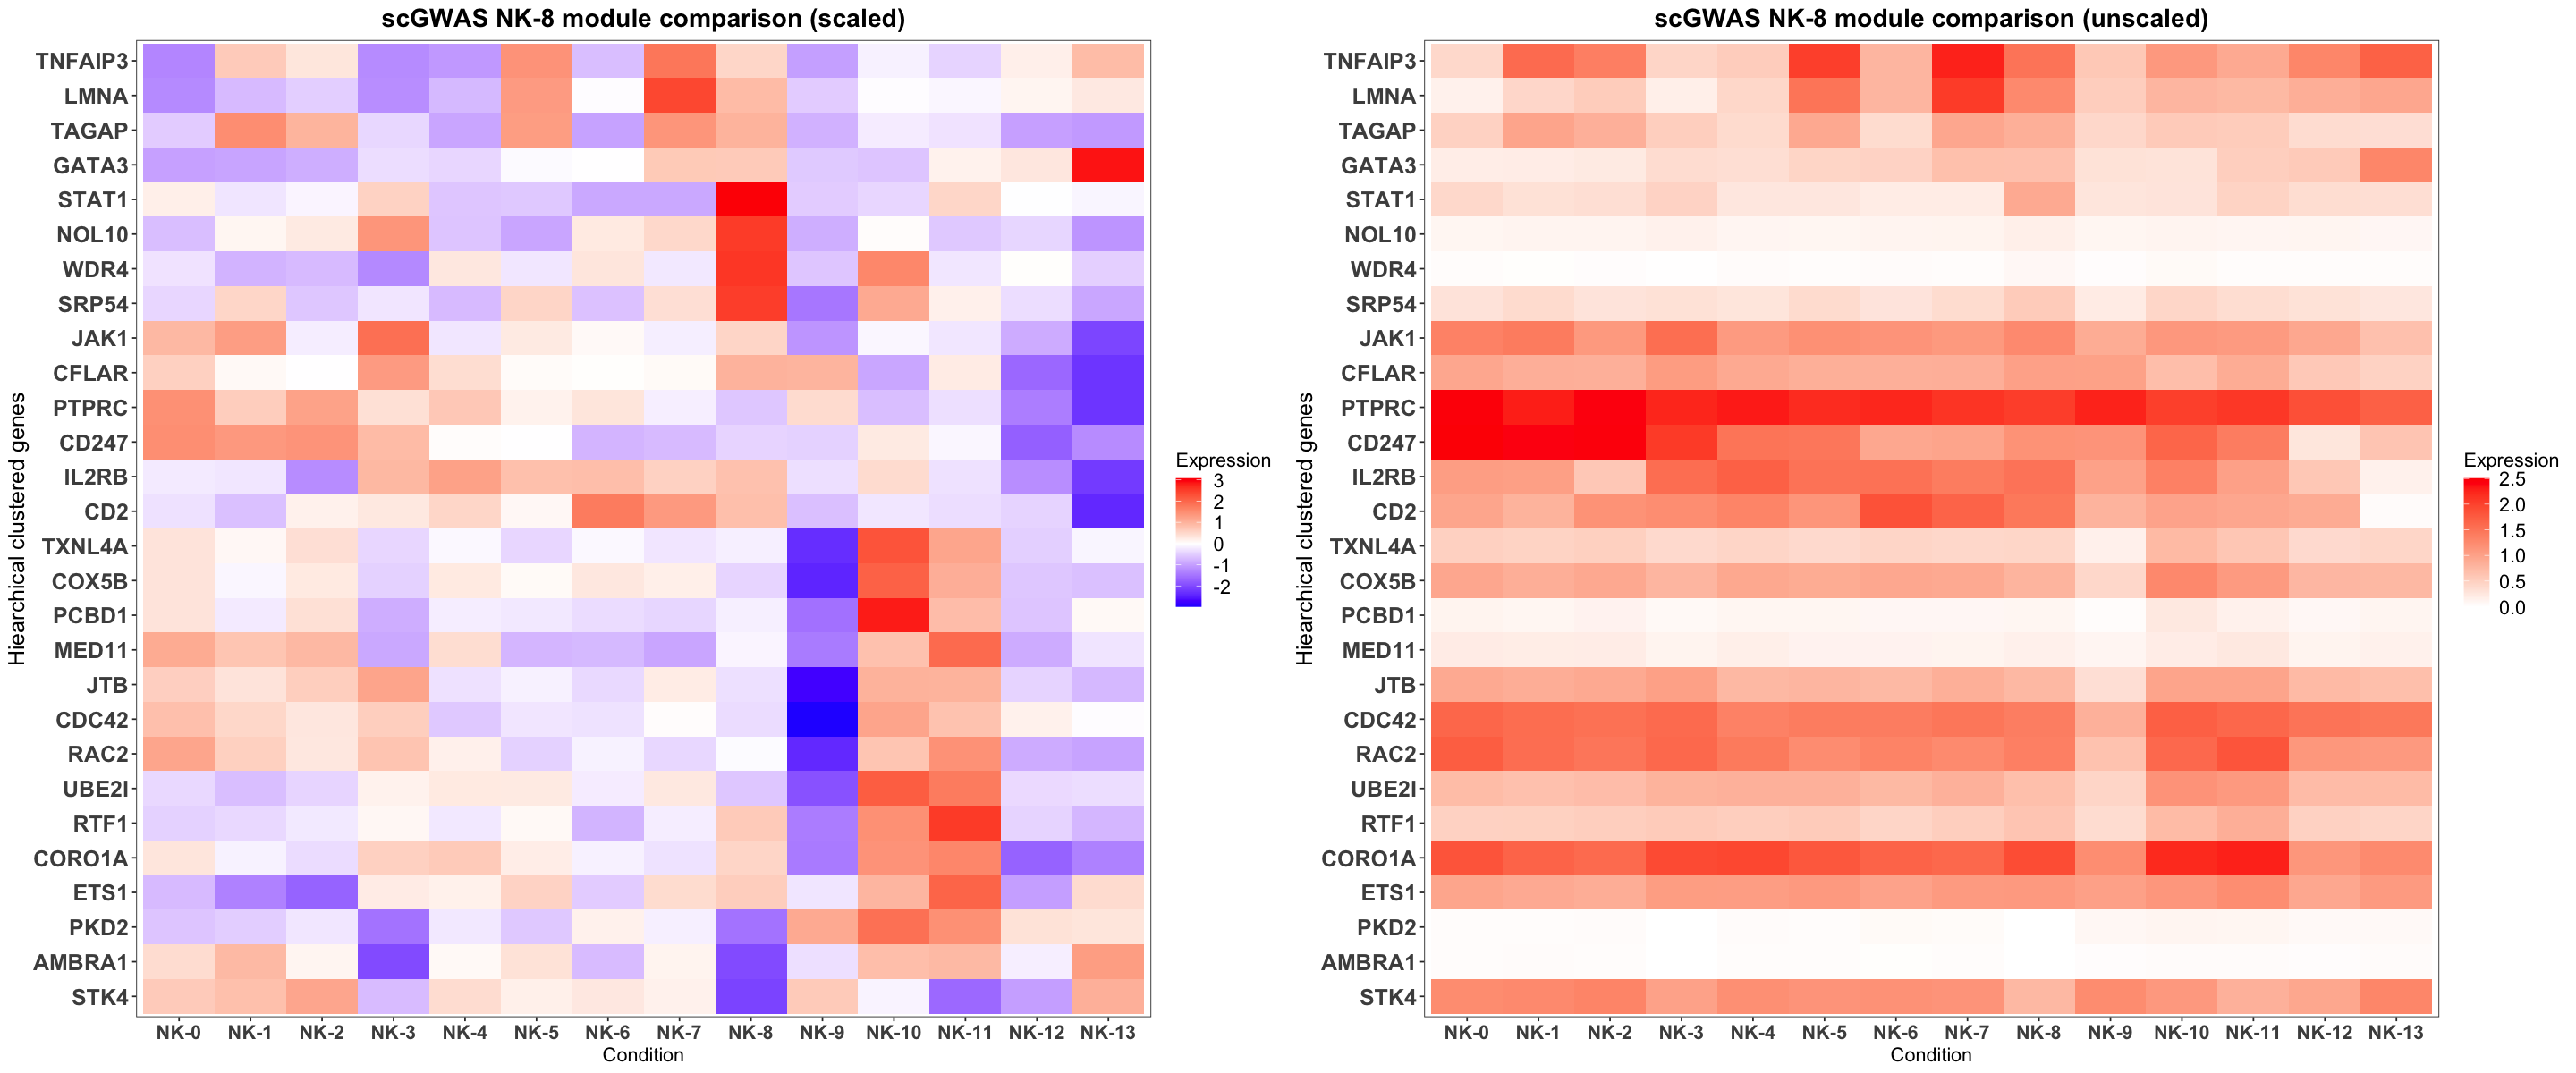

In [111]:
# geet expressiin of just these genes
exp_special <- t(exp_norm_nk[,nk8_genes])
dim(exp_special)
expression_df <- data.frame(Gene = rownames(exp_special), row.names=rownames(exp_special))
for (cluster_number in unique(meta_data_nk$cluster_num)) {
    filtered_cells <- meta_data_nk[meta_data_nk$cluster_num == cluster_number,]$cell
    #print(length(filtered_cells))
    filtered <- exp_special[,filtered_cells]
    Means <- data.frame(apply(t(filtered), 2, mean, na.rm = TRUE))
    colnames(Means) <- cluster_number
    expression_df <- cbind(expression_df, Means)
    }
expression_df[1:2,]

# # scale it for better comparison
expression_df_new <- t(scale(t(expression_df[,!colnames(expression_df) %in% c("Gene")])))
# do hclustering
hclustering <- hclust( dist(expression_df_new, method = "euclidean"), method = "ward.D" )
ord <- hclustering$order
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))

# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
gather_gene_sum_cond_df[1:2,]

defaultW <- getOption("warn") 
options(warn = -1) 
p1 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=nk_order), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS NK-8 module comparison (scaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
              axis.title.y=element_text(size=15), axis.title.x=element_text(size=13), 
              axis.text.y=element_text(size=15, face='bold'), axis.text.x=element_text(size=13, face='bold'), 
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")

# # scale it for better comparison
expression_df_new <- expression_df[,!colnames(expression_df) %in% c("Gene")]
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))


# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
gather_gene_sum_cond_df[1:2,]

p2 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=nk_order), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS NK-8 module comparison (unscaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
              axis.title.y=element_text(size=15), axis.title.x=element_text(size=13), 
              axis.text.y=element_text(size=15, face='bold'), axis.text.x=element_text(size=13, face='bold'), 
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")
options(repr.plot.height = 10, repr.plot.width = 24)
plot_full <- plot_grid(p1, p2)
#ggsave("plot_zhang_mon_vs_mac.png",plot_full, height=10, width=18)
plot_full

[1]   63 7925

,Gene,NK-5,NK-1,NK-9,NK-12,NK-11,NK-6,NK-4,NK-0,NK-7,NK-2,NK-10,NK-13,NK-3,NK-8
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD2,CD2,1.136551,0.8101938,0.805710,0.8947857,0.9440682,1.8654010,1.326338,0.9622944,1.6808507,1.168625,0.984075,0.03669086,1.222671,1.463067
CD247,CD247,1.464216,2.4072643,1.147857,0.2656062,1.4042054,0.9379198,1.497538,2.5039652,0.9802829,2.451345,1.659684,0.62595130,2.080928,1.167564


,Gene,Condition,Expression
,<chr>,<chr>,<dbl>
1,CD2,NK-5,0.098895544
2,CD247,NK-5,-0.009852248


,Gene,Condition,Expression
,<chr>,<chr>,<dbl>
1,CD2,NK-5,1.136551
2,CD247,NK-5,1.464216


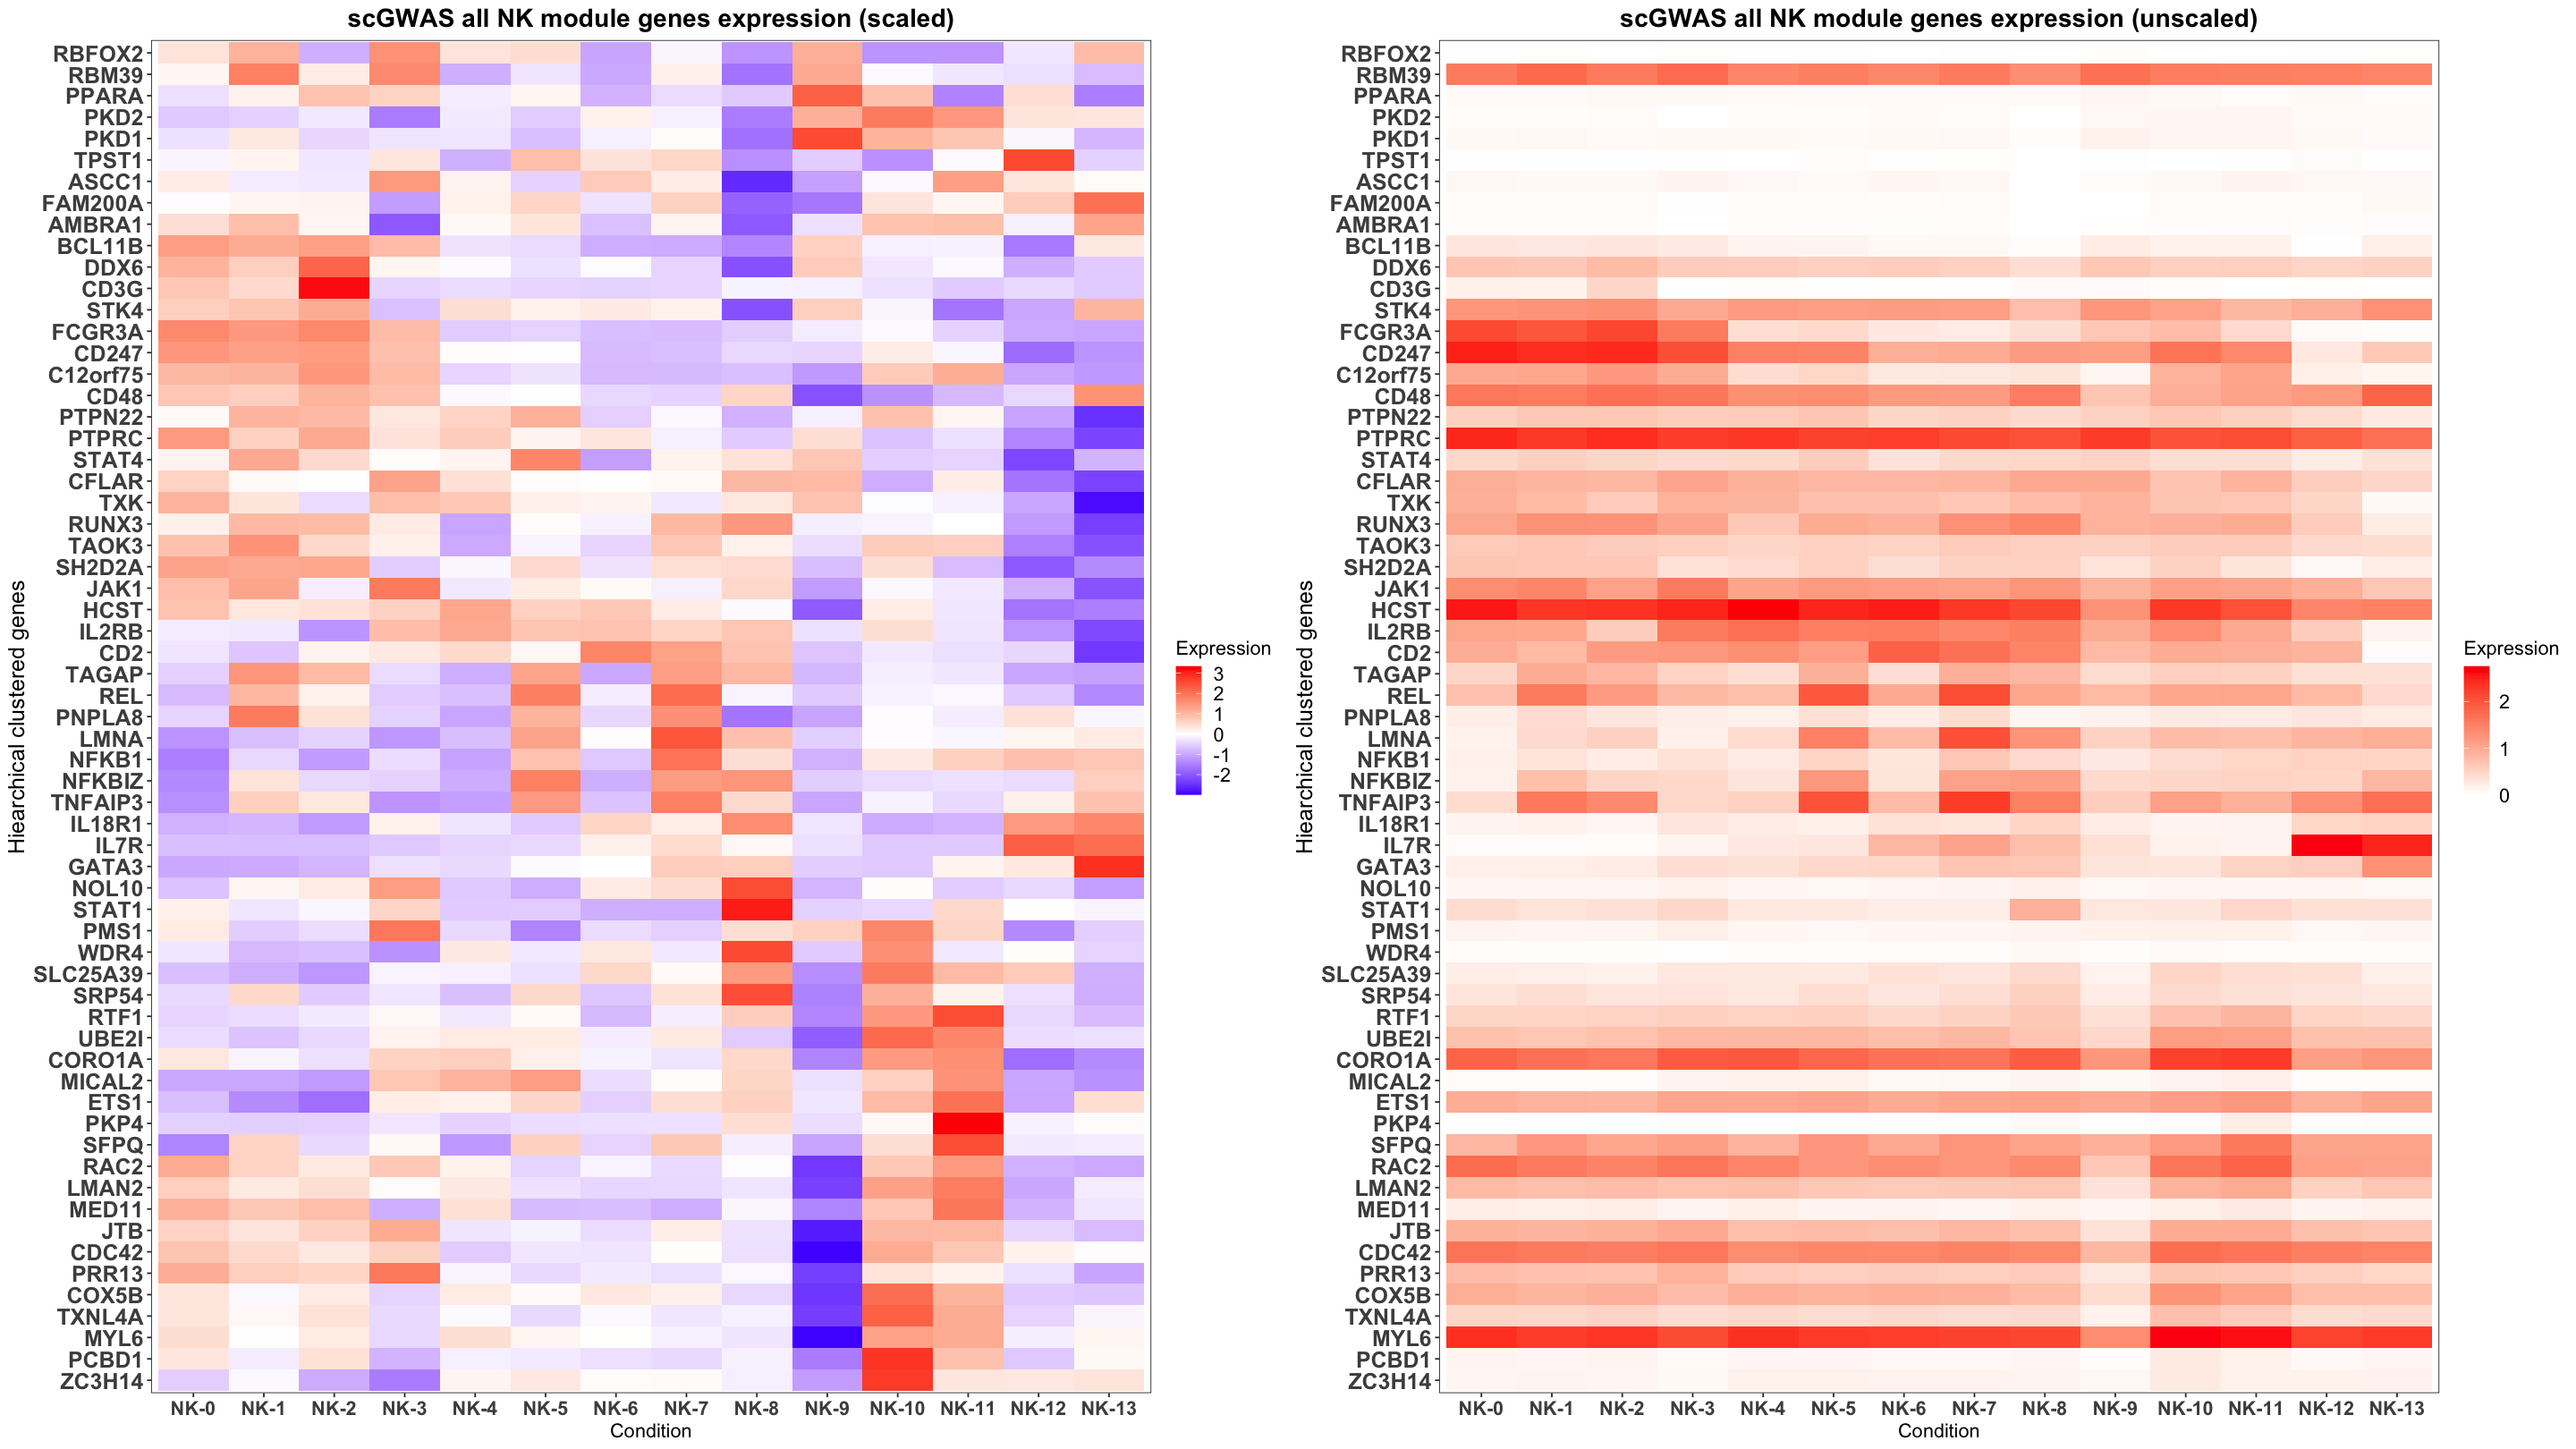

In [115]:
# geet expressiin of just these genes
exp_special <- t(exp_norm_nk[,all_nk_genes])
dim(exp_special)
expression_df <- data.frame(Gene = rownames(exp_special), row.names=rownames(exp_special))
for (cluster_number in unique(meta_data_nk$cluster_num)) {
    filtered_cells <- meta_data_nk[meta_data_nk$cluster_num == cluster_number,]$cell
    #print(length(filtered_cells))
    filtered <- exp_special[,filtered_cells]
    Means <- data.frame(apply(t(filtered), 2, mean, na.rm = TRUE))
    colnames(Means) <- cluster_number
    expression_df <- cbind(expression_df, Means)
    }
expression_df[1:2,]

# # scale it for better comparison
expression_df_new <- t(scale(t(expression_df[,!colnames(expression_df) %in% c("Gene")])))
# do hclustering
hclustering <- hclust( dist(expression_df_new, method = "euclidean"), method = "ward.D" )
ord <- hclustering$order
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))

# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
gather_gene_sum_cond_df[1:2,]

defaultW <- getOption("warn") 
options(warn = -1) 
p1 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=nk_order), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS all NK module genes expression (scaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
              axis.title.y=element_text(size=15), axis.title.x=element_text(size=13), 
              axis.text.y=element_text(size=15, face='bold'), axis.text.x=element_text(size=13, face='bold'), 
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")

# # scale it for better comparison
expression_df_new <- expression_df[,!colnames(expression_df) %in% c("Gene")]
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))


# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
gather_gene_sum_cond_df[1:2,]

p2 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=nk_order), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS all NK module genes expression (unscaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
              axis.title.y=element_text(size=15), axis.title.x=element_text(size=13), 
              axis.text.y=element_text(size=15, face='bold'), axis.text.x=element_text(size=13, face='bold'), 
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")
options(repr.plot.height = 13.5, repr.plot.width = 24)
plot_full <- plot_grid(p1, p2)
#ggsave("plot_zhang_mon_vs_mac.png",plot_full, height=10, width=18)
plot_full

In [21]:
exp_norm_nk[1:2,1:3]
exp_norm_nk_scale[1:2,1:3]
exp_norm_nk_colSum[1:2,1:3]

2 x 3 sparse Matrix of class "dgCMatrix"
            BRI-401_AACACACGTCGGTACC BRI-401_AACCAACTCACTGAAC
MIR1302-2HG                        .                        .
FAM138A                            .                        .
            BRI-401_AAGAACAAGAACTTCC
MIR1302-2HG                        .
FAM138A                            .

,BRI-401_AACACACGTCGGTACC,BRI-401_AACCAACTCACTGAAC,BRI-401_AAGAACAAGAACTTCC
MIR1302-2HG,-0.1968724,-0.2138413,-0.2041595
FAM138A,-0.1968724,-0.2138413,-0.2041595


2 x 3 sparse Matrix of class "dgCMatrix"
            BRI-401_AACACACGTCGGTACC BRI-401_AACCAACTCACTGAAC
MIR1302-2HG                        .                        .
FAM138A                            .                        .
            BRI-401_AAGAACAAGAACTTCC
MIR1302-2HG                        .
FAM138A                            .

In [110]:
plot_heatmap <- function(gene_list, num) {

    # geet expressiin of just these genes
exp_special <- exp_norm_nk[unique(gene_list),]
dim(exp_special)
expression_df <- data.frame(Gene = rownames(exp_special), row.names=rownames(exp_special))
for (cluster_number in unique(meta_data_nk$cluster_num)) {
    filtered_cells <- meta_data_nk[meta_data_nk$cluster_num == cluster_number,]$cell
    #print(length(filtered_cells))
    filtered <- exp_special[,filtered_cells]
    Means <- data.frame(apply(t(filtered), 2, mean, na.rm = TRUE))
    colnames(Means) <- str_split(cluster_number, "-")[[1]][2]
    expression_df <- cbind(expression_df, Means)
    }
#print(expression_df[1:2,])

# # scale it for better comparison
expression_df_new <- t(scale(t(expression_df[,!colnames(expression_df) %in% c("Gene")])))
# do hclustering
hclustering <- hclust( dist(expression_df_new, method = "euclidean"), method = "ward.D" )
ord <- hclustering$order
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))

# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
#print(gather_gene_sum_cond_df[1:2,])

defaultW <- getOption("warn") 
options(warn = -1) 
p1 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=seq(0,13)), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS NK-8 module gene expression (unscaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              #axis.title.x=element_blank(), axis.text.x=element_blank(),axis.ticks = element_blank(), axis.title.y=element_blank(),
              axis.title.x=element_text(size=13),axis.text.x=element_text(size=13, face='bold'), axis.title.y=element_text(size=15), 
              panel.grid.major.x = element_blank(), panel.grid.minor = element_blank(), 
              axis.text.y=element_text(size=15, face='bold'),
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")

# # scale it for better comparison
expression_df_new <- expression_df[,!colnames(expression_df) %in% c("Gene")]
expression_df_new <- cbind(expression_df_new, data.frame("Gene"=expression_df[,c("Gene")]))


# now change to long form for heatmap
gather_gene_sum_cond_df <- gather(expression_df_new, key="Condition", value="Expression", 1:14)
gather_gene_sum_cond_df[1:2,]

p2 <- ggplot(gather_gene_sum_cond_df, aes(x=factor(Condition, levels=seq(0,13)), 
                                          y=factor(Gene, levels=expression_df_new$Gene[ord]), fill= Expression)) + 
    ggtitle("scGWAS NK-8 module gene expression (scaled)") +
  geom_tile() +
  scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
    theme_bw() +
        theme(plot.title = element_text(size=17, hjust=0.5, face='bold'), 
              # remove legend
             #legend.position="none", 
              # remove grid lines
              #axis.title.x=element_blank(), axis.text.x=element_blank(),axis.ticks = element_blank(), axis.title.y=element_blank(),
              axis.title.x=element_text(size=13),axis.text.x=element_text(size=12, face='bold'), axis.title.y=element_text(size=15), 
              panel.grid.major.x = element_blank(), panel.grid.minor = element_blank(), 
              axis.text.y=element_text(size=15, face='bold'), 
              legend.text=element_text(size=13), legend.title = element_text(size=13)
             )  +
    labs(x="Condition", y="Hiearchical clustered genes")
options(repr.plot.height = 2, repr.plot.width = 13.5)
    options(repr.plot.height = 3, repr.plot.width = 13.5)
plot_full <- plot_grid(p1, p2)
#ggsave(paste0("./NK8/NK8_module_", num, ".png"), height=2, width=13.5)
plot_full
    
    }

    
# STAT1, NOL10, WDR4, SRP54

In [31]:
gene_list1 <- str_split(scgwas_results[scgwas_results$cell_type == "NK-8: CD56bright CD16- IFN response",]$module_genes, ":")
gene_list2 <- scgwas_results[scgwas_results$cell_type == "NK-8: CD56bright CD16- IFN response",]$seed
gene_list2

[1] "PCBD1"  "NOL10"  "TXNL4A" "MED11"  "AMBRA1" "SRP54"  "JTB"    "UBE2I" 
 [9] "WDR4"   "PKD2"   "COX5B"

In [32]:
#10,1,5,12,11
filtered <- scgwas_results[scgwas_results$cell_type == "NK-8: CD56bright CD16- IFN response",]

# for each filtered, get the full list
full_nk8_list <- c()
for (index in seq(1, nrow(filtered))) {
    full_nk8_list <- c(full_nk8_list, list(c(gene_list1[[index]], 
                                           gene_list2[[index]])))
}
full_nk8_list

[[1]]
[1] "CORO1A"  "ETS1"    "JAK1"    "PTPRC"   "STAT1"   "TNFAIP3" "PCBD1"  

[[2]]
[1] "CD2"     "CDC42"   "IL2RB"   "PTPRC"   "STAT1"   "TNFAIP3" "NOL10"  

[[3]]
[1] "CD2"     "IL2RB"   "JAK1"    "PTPRC"   "STAT1"   "TNFAIP3" "TXNL4A" 

[[4]]
[1] "CORO1A"  "ETS1"    "GATA3"   "PTPRC"   "STAT1"   "TNFAIP3" "MED11"  

[[5]]
[1] "CD2"    "CD247"  "CFLAR"  "CORO1A" "ETS1"   "IL2RB"  "AMBRA1"

[[6]]
[1] "CORO1A"  "ETS1"    "PTPRC"   "STAT1"   "STK4"    "TNFAIP3" "SRP54"  

[[7]]
[1] "CD2"     "IL2RB"   "PTPRC"   "STAT1"   "TNFAIP3" "JTB"    

[[8]]
[1] "CORO1A"  "ETS1"    "PTPRC"   "STAT1"   "TNFAIP3" "UBE2I"   "UBE2I"  

[[9]]
[1] "CD2"    "CD247"  "CORO1A" "ETS1"   "RAC2"   "TAGAP"  "WDR4"  

[[10]]
[1] "CD2"     "LMNA"    "PTPRC"   "RTF1"    "STAT1"   "TNFAIP3" "PKD2"   

[[11]]
[1] "CD2"     "CD247"   "IL2RB"   "STAT1"   "TNFAIP3" "COX5B"

In [51]:
length(full_nk8_list)
as.character(seq(1, length(full_nk8_list)))

[1] 11

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11"

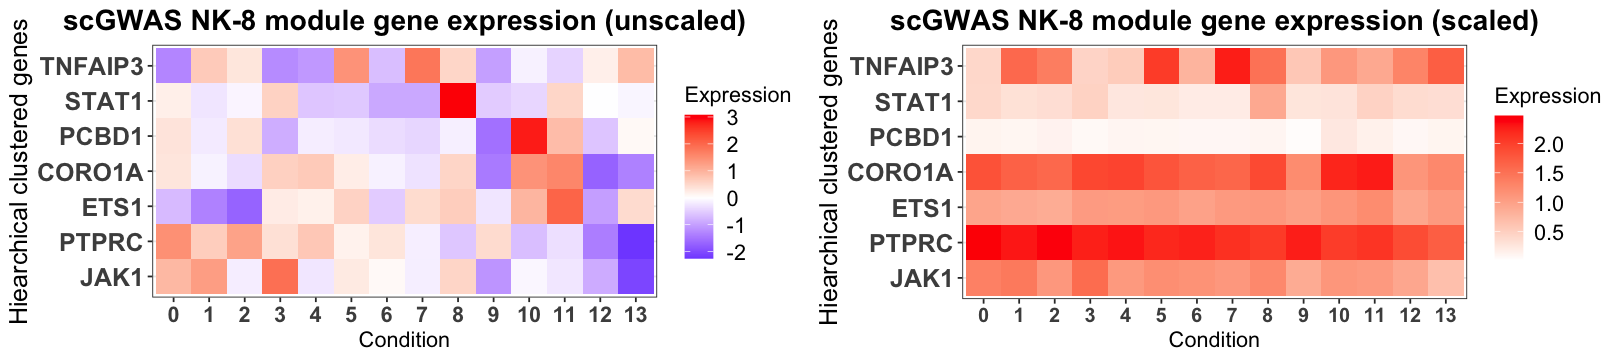

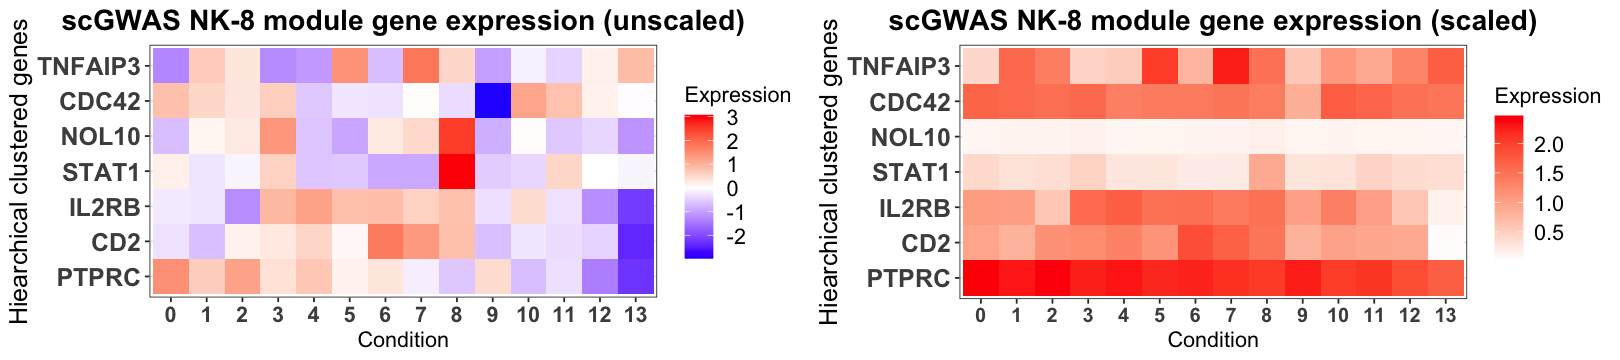

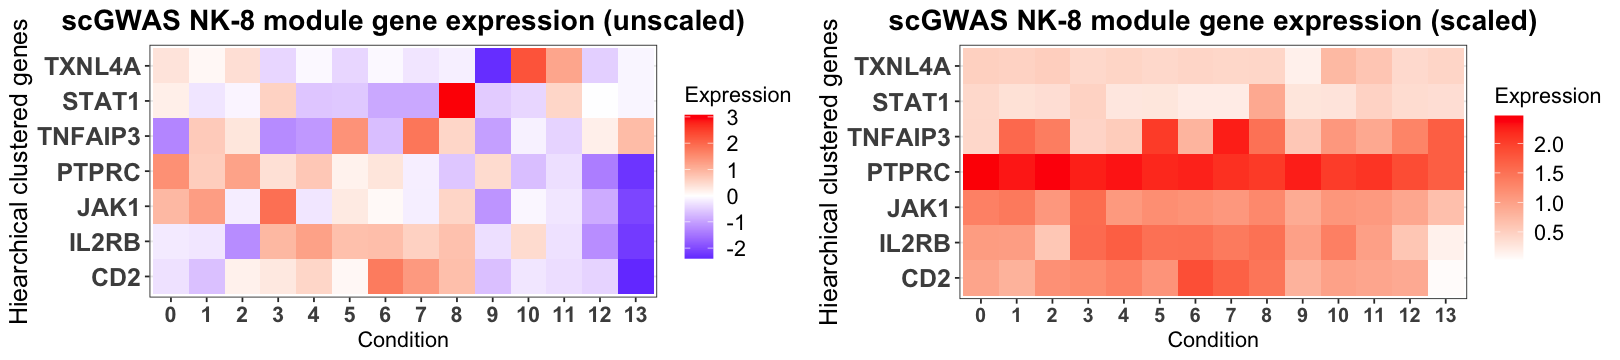

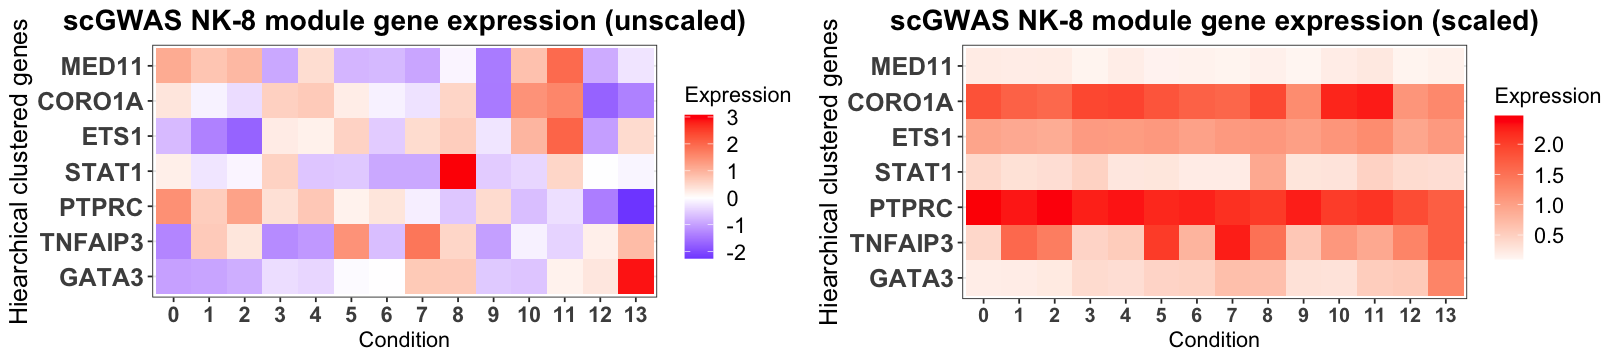

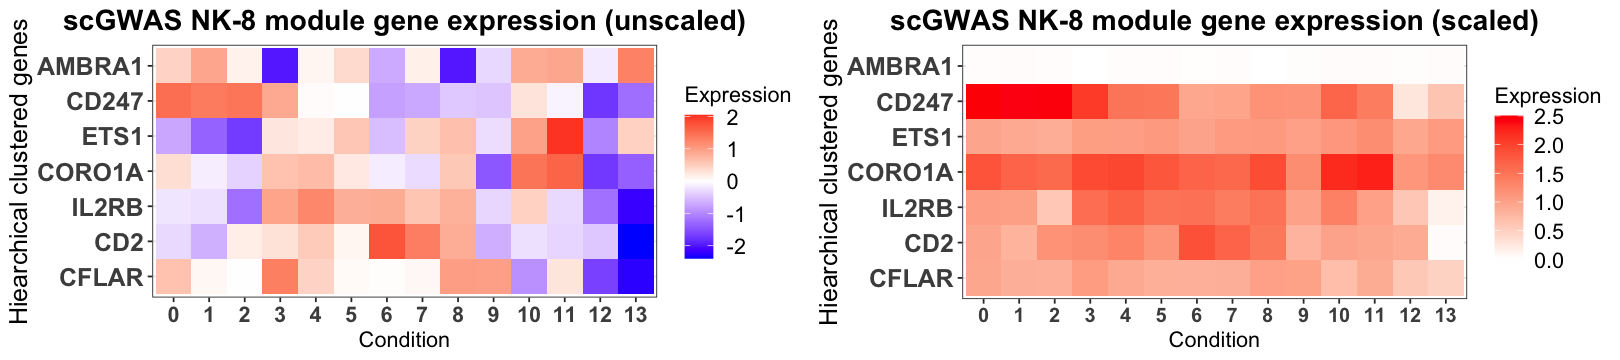

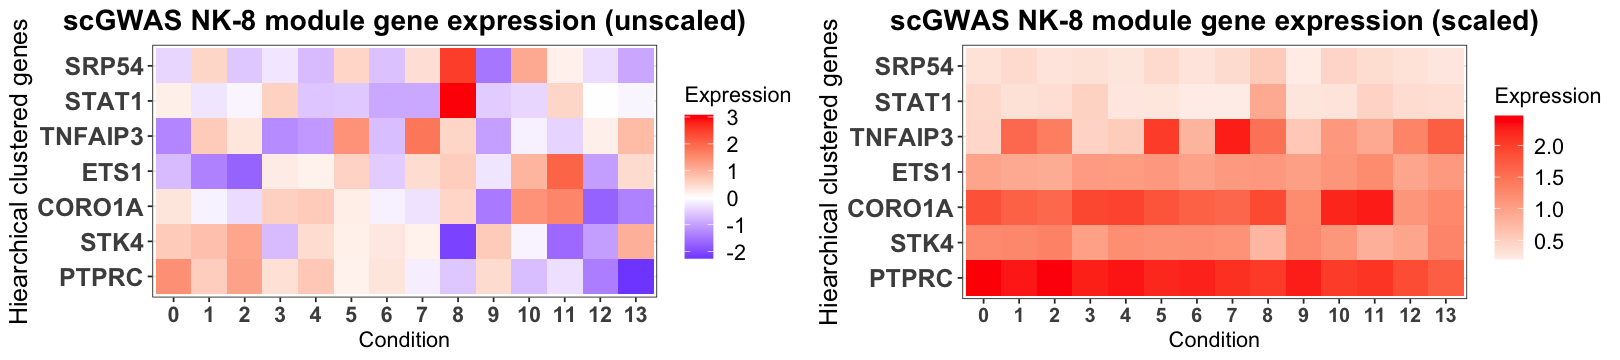

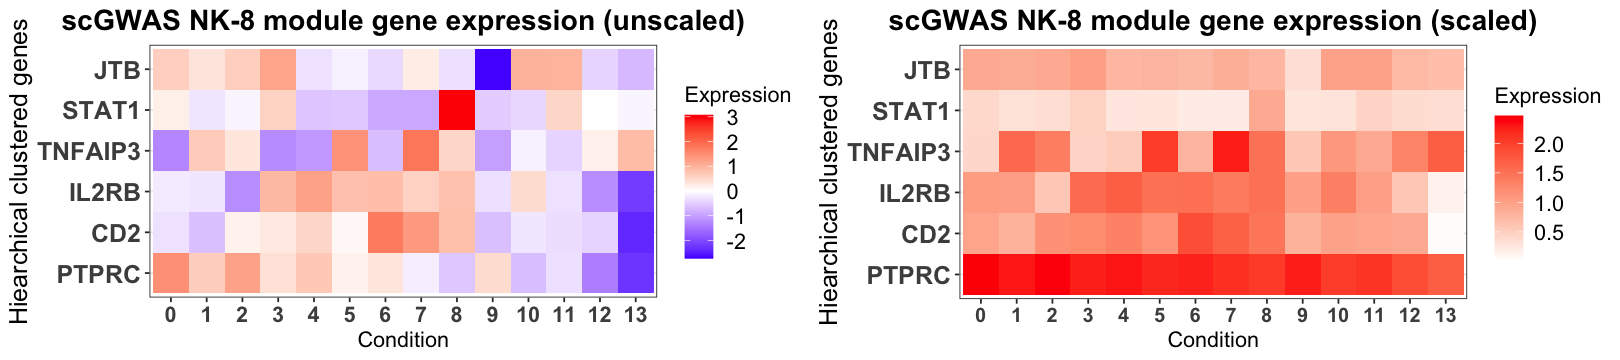

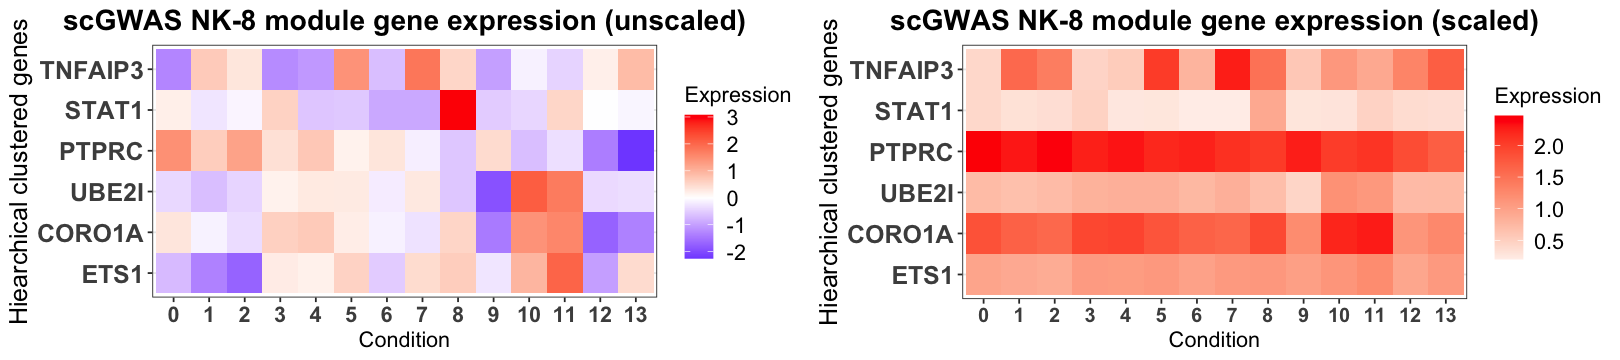

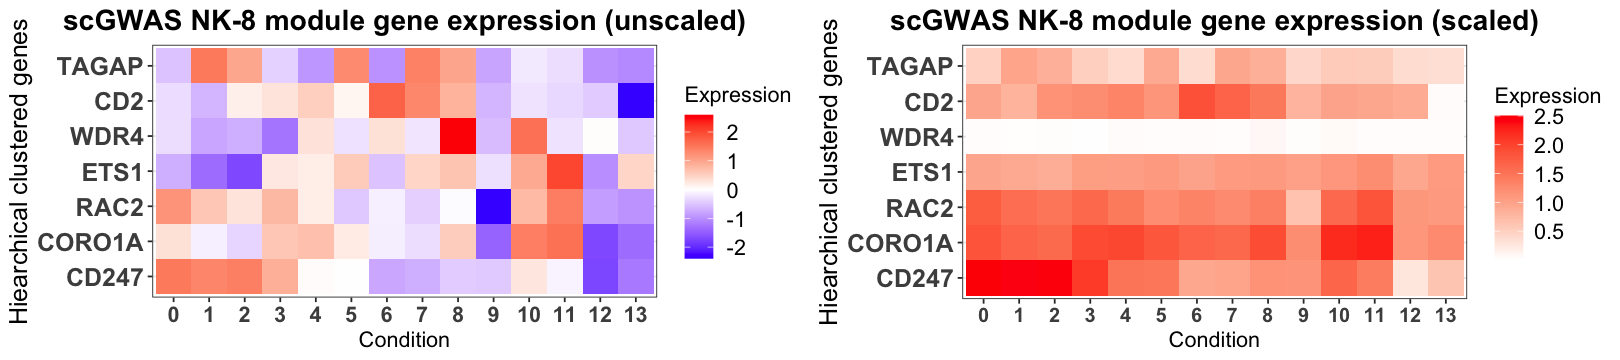

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


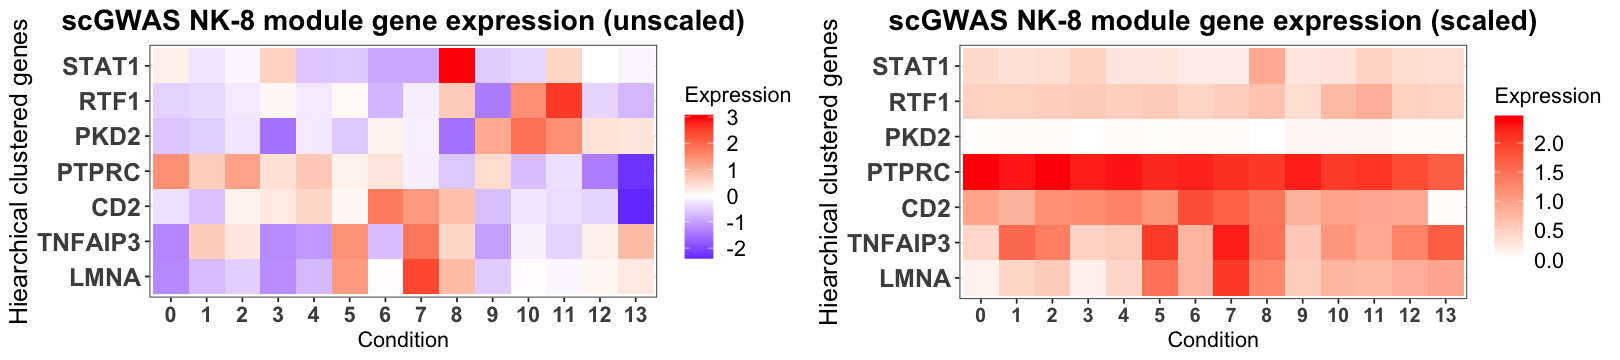

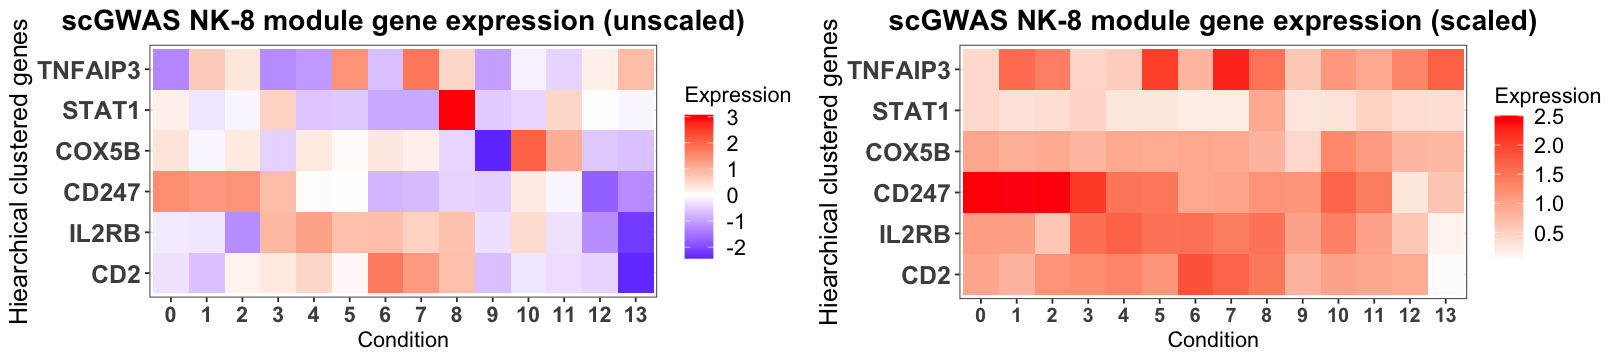

In [111]:
plot_full2 <- map2(full_nk8_list, as.character(seq(1, length(full_nk8_list))), plot_heatmap)
plot_full2
#ggsave(plot_full2, "NK8_modules_heatmap.png", height=44, width=20)